In [11]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import csv
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    AddChannel,
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    Lambda,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    Resize,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.1.0
Numpy version: 1.24.1
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /illukas/home/mapari/treenimine/jupyter/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
py

In [12]:
os.environ["MONAI_DATA_DIRECTORY"] = './'
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
image_dir = '/illukas/data/projects/radiology/kaggle_chest_xray/chest_xray'
print(root_dir)
print(os.getcwd())

train_dir = image_dir + "/train"
val_dir = image_dir + "/val"
test_dir = image_dir + "/test"

normal_dir = "/NORMAL/"
pneumonia_dir = "/PNEUMONIA/"

normal_dir_augment = directory + 'our_images' + normal_dir
pneumonia_dir_augment = directory + 'our_images' + pneumonia_dir

./
/illukas/home/mapari/treenimine


In [13]:
# dataset downloaded via
# https://data.mendeley.com/datasets/rscbjbr9sj/2

In [14]:
set_determinism(seed=0)


In [15]:
train = 'TRAIN'
validation = 'VALIDATION'
test= 'TEST'

none = 'none'
pneumonia = 'pneumonia'
class_names = [none, pneumonia]

num_class=2

files = {
    train: [],
    validation: [],
    test: []
}

labels = {
    train: [],
    validation: [],
    test: []
}

# validation set is unproportinally small; transfer 1/5 of files from training to validation 
counter = 0
for filename in os.listdir(train_dir + normal_dir):
    if counter % 5 != 0:
        files[train].append(train_dir + normal_dir + filename)
        labels[train].append(0)
    else:
        files[validation].append(train_dir + normal_dir + filename)
        labels[validation].append(0)
    counter = counter + 1

for filename in os.listdir(train_dir + pneumonia_dir):
    if counter % 5 != 0:
        files[train].append(train_dir + pneumonia_dir + filename)
        labels[train].append(1)
    else:
        files[validation].append(train_dir + pneumonia_dir + filename)
        labels[validation].append(1)
    counter = counter + 1
    
# add false results from last testing    
for filename in os.listdir(normal_dir_augment):
    files[train].append(normal_dir_augment + filename)
    labels[train].append(0)

for filename in os.listdir(pneumonia_dir_augment):
    files[train].append(pneumonia_dir_augment + filename)
    labels[train].append(1)
    
    
    
    
    
for filename in os.listdir(val_dir + normal_dir):
    files[validation].append(val_dir + normal_dir + filename)
    labels[validation].append(0)
    
for filename in os.listdir(val_dir + pneumonia_dir):
    files[validation].append(val_dir + pneumonia_dir + filename)
    labels[validation].append(1)
    
for filename in os.listdir(test_dir + normal_dir):
    files[test].append(test_dir + normal_dir + filename)
    labels[test].append(0)
    
for filename in os.listdir(test_dir + pneumonia_dir):
    files[test].append(test_dir + pneumonia_dir + filename)
    labels[test].append(1)


for n in range(5):
    image_width, image_height = PIL.Image.open(files[train][n]).size
    print(f"Image dimensions: {image_width} x {image_height}")

print(len(files[train]))
print(len(labels[train]))
print(len(files[validation]))
print(len(labels[validation]))
print(len(files[test]))
print(len(labels[test]))

print(files[train][33])
print(labels[train][33])

Image dimensions: 1450 x 1210
Image dimensions: 1692 x 1221
Image dimensions: 1458 x 1233
Image dimensions: 1542 x 1286
Image dimensions: 1687 x 1595
4182
4182
1060
1060
624
624
/illukas/data/projects/radiology/kaggle_chest_xray/chest_xray/train/NORMAL/IM-0147-0001.jpeg
0


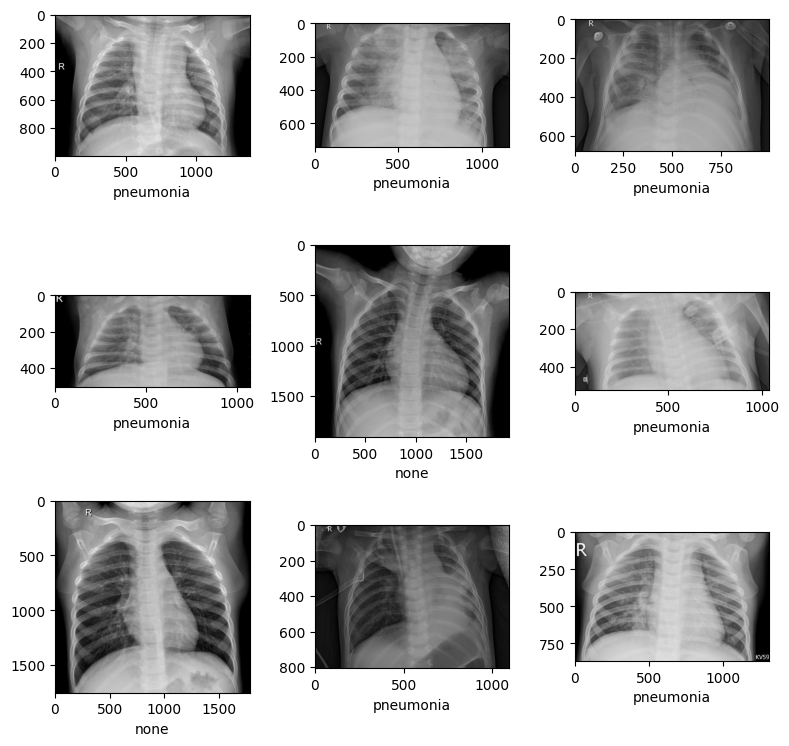

In [16]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(len(files[train]), size=9)):
    im = PIL.Image.open(files[train][k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(pneumonia if labels[train][k] == 1 else none)
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [17]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        Lambda(func=lambda x: np.mean(x, axis=0) if len(x.shape) == 3 else x),
        AddChannel(),
        ScaleIntensity(),
        Resize([256, 256]),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)


val_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        Lambda(func=lambda x: np.mean(x, axis=0) if len(x.shape) == 3 else x),
        AddChannel(),
        ScaleIntensity(),
        Resize([256, 256]),
    ]
)

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [18]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]



train_ds = MedNISTDataset(files[train], labels[train], train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=100, shuffle=True, num_workers=8)
 #   train_ds, batch_size=30, num_workers=8)

val_ds = MedNISTDataset(files[validation], labels[validation], val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=100, num_workers=8)

test_ds = MedNISTDataset(files[test], labels[test], val_transforms)
test_loader = DataLoader(
    test_ds, batch_size=100, num_workers=8)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [20]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/100
1/41, train_loss: 0.6709
2/41, train_loss: 0.6635
3/41, train_loss: 0.6622
4/41, train_loss: 0.6398
5/41, train_loss: 0.6259
6/41, train_loss: 0.6226
7/41, train_loss: 0.6114
8/41, train_loss: 0.6062
9/41, train_loss: 0.5941
10/41, train_loss: 0.5939
11/41, train_loss: 0.5966
12/41, train_loss: 0.5857
13/41, train_loss: 0.5802
14/41, train_loss: 0.5762
15/41, train_loss: 0.5863
16/41, train_loss: 0.5605
17/41, train_loss: 0.5487
18/41, train_loss: 0.5457
19/41, train_loss: 0.5330
20/41, train_loss: 0.5237
21/41, train_loss: 0.5478
22/41, train_loss: 0.5263
23/41, train_loss: 0.5063
24/41, train_loss: 0.5347
25/41, train_loss: 0.5035
26/41, train_loss: 0.5137
27/41, train_loss: 0.5106
28/41, train_loss: 0.4762
29/41, train_loss: 0.4999
30/41, train_loss: 0.4582
31/41, train_loss: 0.4785
32/41, train_loss: 0.4694
33/41, train_loss: 0.4622
34/41, train_loss: 0.5025
35/41, train_loss: 0.4631
36/41, train_loss: 0.4529
37/41, train_loss: 0.4610
38/41, train_loss: 0.487

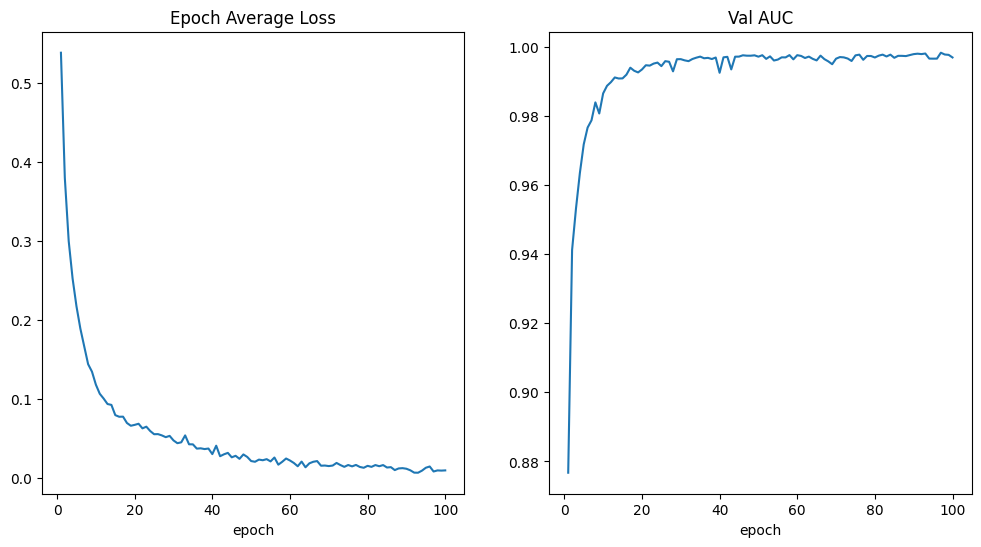

In [21]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [22]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [23]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

        none     0.9700    0.4145    0.5808       234
   pneumonia     0.7385    0.9923    0.8468       390

    accuracy                         0.7756       624
   macro avg     0.8543    0.7034    0.7138       624
weighted avg     0.8253    0.7756    0.7471       624



In [25]:
print(os.path.join(root_dir, "best_metric_model.pth"))

./best_metric_model.pth


In [26]:
torch.jit.script(model).save(root_dir + "classifier2.zip")